# Random Forest Tutorial

This notebook servers as an introduction to Random Forest which is a tree based ensemble learning algorithms. In this notebook I will cover the technical details behind random forest and it's suitability as a (supervised) anomaly detection tool.

## Decision Trees
Given:<br/>
$D = \{(x_1, y_1), ...., (x_n, y_n)\}$<br/>
$h_k(x)$ is the $k_{th}$ decision tree and $h_k(x) = h(x | \theta_k)$ where $\theta_k = (\theta_{k1}, \theta_{k2},....\theta_{kp})$ are the parameters of the decision tree which include the structure of the tree, which features are used at which node to create a new split, split value at a particular node etc. When used in ensembles, each decision tree works on a particular sub sample of the training data (sampled without replacement). This sampling parameter is encapsulated in the ensemble model parameter $\Theta$.


## Random Forest

It is simply an ensemble of many such trees and calculates the final class value for a given sample by majority vote.
\begin{equation}
\therefore f(x) = Mode\{h_k(x)\}
\end{equation}

Each tree is grown as follows:

* If the number of cases in the training set is N, sample N cases at random - but with replacement, from the original data. This sample will be the training set for growing the tree. 
* If there are M input features, a number m<<M is specified such that at each node, m features are selected at random out of the M and the best split on these m is used to split the node. The value of m is held constant during the forest growing.
* Each tree is grown to the largest extent possible. There is no pruning.
* The unbiased error estimate is obtained as the *out-of-bag (oob) error estimate*.About 1/3rd of samples from the training dataset are left out when growing a tree. After the tree is fully grown then class estimate for every sample that is *oob* is obtained by majority vote and this prediction is then compared to the label.

In the original paper on random forests, it was shown that the forest error rate depends on two things:

* The *correlation* between any two trees in the forest. Increasing the correlation increases the forest error rate.
* The *strength* of each individual tree in the forest. A tree with a low error rate is a strong classifier. Increasing the strength of the individual trees decreases the forest error rate.

In [43]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, zero_one_loss
from resources.utils import conf_matrix, read_mat

# default plot settings
plt.rcParams['figure.figsize'] = [16, 14]
plt.rcParams['axes.facecolor'] = 'turquoise'
plt.rcParams['axes.titlepad'] = 15.0
rng = np.random.RandomState(42)

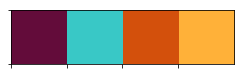

In [44]:
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)
def plot_data(dframe,x='x', y='y',col='label'):
    sns.lmplot(data=dframe, x=x, y=y, col=col, 
                   fit_reg=False, legend=True, legend_out=True)

In [45]:
def plot_prep(data_splits, model, actual_inlier, model_inlier, model_name="model"):
    X_test, y_test = data_splits
    y_pred = model.predict(X_test)    
    y_test_new = []
    for yt in y_test.tolist():
        if yt==actual_inlier:
            y_test_new.append('Good')
        else:
            y_test_new.append('Bad')
            
    y_pred_new = []
    for yt in y_pred.tolist():
        if yt==model_inlier:
            y_pred_new.append('Good')
        else:
            y_pred_new.append('Bad')
        
    data = np.stack((X_test[:, 2], X_test[:,1], y_test_new, y_pred_new)).T
    new_df = pd.DataFrame(data, columns=['x', 'y', '{}.actual'.format(model_name), '{}.predicted'.format(model_name)])
    new_df['x'] = new_df['x'].astype('float')
    new_df['y'] = new_df['y'].astype('float')
    return (new_df, 'x', 'y', ('{}.actual'.format(model_name), '{}.predicted'.format(model_name)))

In [46]:
def conf_prep(df, model_name):
    y_act = df['{}.actual'.format(model_name)].values.tolist()
    y_pred = df['{}.predicted'.format(model_name)].values.tolist()
    
    y_act = [0 if x=='Good' else 1 for x in y_act]
    y_pred = [0 if x=='Good' else 1 for x in y_pred]
    return (y_act, y_pred, [0,1])

In [47]:
filepath = 'resources/anomaly_datasets/mammography.mat'
df_mammography = read_mat(filepath)
df_mammography.head()

,feat-1,feat-2,feat-3,feat-4,feat-5,feat-6,label
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0


In [50]:
Data = df_mammography.iloc[:,0:df_mammography.shape[1]-1].values
Target = df_mammography['label'].values
X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.2, random_state=rng, stratify=Target)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

#criterion = measure the quality of a split, a good split will lead to better class division among samples.

#A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples 
#in each of the left and right branches.

#max_features = no. of features to consider when looking for the best split. When "auto", max_features = sqrt(num_features)

rfc = RandomForestClassifier(n_estimators=1000, random_state=rng, max_features=1.,
                                 class_weight='balanced', n_jobs=-1)

rfc.fit(X_train,y_train)

Training Features Shape: (8946, 6)
Training Labels Shape: (8946,)
Testing Features Shape: (2237, 6)
Testing Labels Shape: (2237,)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7fcf9c9b6b88>,
            verbose=0, warm_start=False)

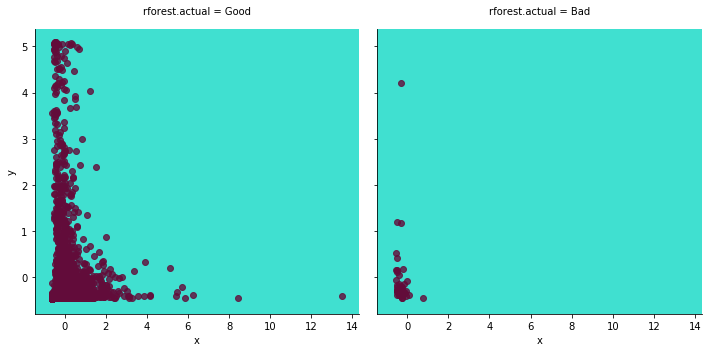

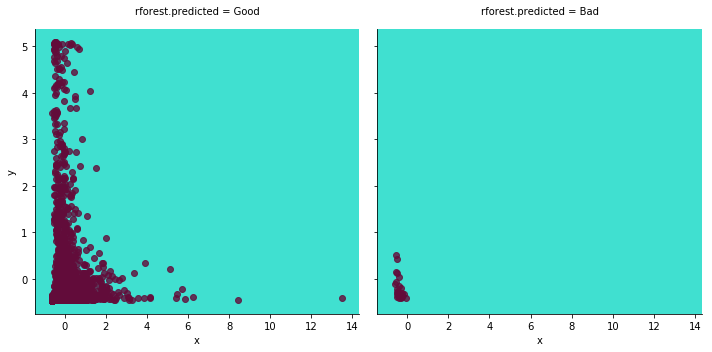

In [51]:
df1_rf, plot_x, plot_y, cols = plot_prep((X_test, y_test),rfc, 0, 0, "rforest")
plot_data(df1_rf, x=plot_x, y=plot_y, col=cols[0])
plot_data(df1_rf, x=plot_x, y=plot_y, col=cols[1])

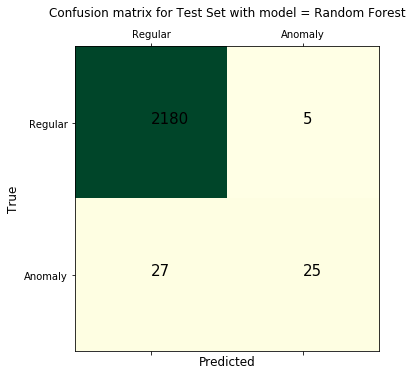

In [52]:
test1_rf, pred1_rf, labels1_ref = conf_prep(df1_rf, "rforest")
fig = plt.figure(figsize=(12,10))
conf_matrix(test1_rf, pred1_rf, fig, labels= labels1_ref, model_name="Random Forest", z=1)
plt.show()

In [53]:
print(classification_report(test1_rf, pred1_rf, target_names=['Regular', 'Anomaly']))
print("accuracy of classification = {}%".format(accuracy_score(test1_rf, pred1_rf)*100))
print("misclassification rate = {}%".format(zero_one_loss(test1_rf, pred1_rf)*100))

              precision    recall  f1-score   support

     Regular       0.99      1.00      0.99      2185
     Anomaly       0.83      0.48      0.61        52

   micro avg       0.99      0.99      0.99      2237
   macro avg       0.91      0.74      0.80      2237
weighted avg       0.98      0.99      0.98      2237

accuracy of classification = 98.56951274027715%
misclassification rate = 1.4304872597228457%


### Salient Features of Random Forests:

* Overcome the overfitting problem of decision trees by sampling both the data and features.
* It can handle thousands of input variables without variable deletion.
* It gives estimates of what variables are important in the classification.
* It has methods for balancing error in class population unbalanced data sets.
* The capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection.